### Precision Recall plots for different Models

The models are show for the FMNIST features extracted from RESNET

The file loads the 

all_results_run_{*}.pkl files from the results section

which are  created by the training


Following models are shown:

- Autoencoder
- VAE
- LOF
- SVM
- Isolation Forest
- NTL 
     - blind
     - LOE soft 
          - alpha0 =alpha
          - alpha0 =! alpha for different ratios
     - LOE hard 
          - ""
     - Refine
          - ""

In [1]:
#activate conda env AutencoderTF env tf '2.10.0' , python 3.9.16
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

print(sys.path)
sys.path.append('/root/LatentOE-AD')
from Additional_Code_BULE.utils.helper_functions  import *


root="/root/LatentOE-AD/DATA/fmnist_features/"

/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-08-21 10:34:48.901386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages']


2023-08-21 10:34:48.975057: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 10:34:48.992267: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-21 10:34:49.304415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-21 10:34:49.304444: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-21 10:34:49.304447: W tensorfl

DISPLAY AE3 PR with different conamtination ratios

In [2]:
#Altering code for the report.. original code in the helper_functions.py

def plot_precision_recall_multi(dataframe_list:list, plot:bool=True, show_img:bool=False,contam_list:list=None,sklearn_pr:bool=None,title:str="plot",pred_y:str="mse_",min_max:bool=True )->None:
    """
    Calculates precision-recall for all the classes and contamination ratios for multiple datasets and different runs.
    Adds confidence bands to the precision-recall plot.
    plots the precision recall curves for all classes and contamination ratios
    # only for fmnist data

    Args:
        dataframe_list (list): List of dataframes containing results for different runs/datasets.
        plot (bool): Whether to plot the precision-recall curves. Defaults to True. 
        show_img (bool): Whether to show sample images. Defaults to False.
        contam_list (list): List of contamination ratios. Defaults to None. If None, the contamination ratios are extracted from the dataframe.
        sklearn_pr (bool): Whether to use sklearn precision_recall_curve. Defaults to None. If None, the precision_recall function is used.
        title (str): Title of the plot. Defaults to "plot".
        pred_y (str): which metric to use . Defaults to "mse_". If pred_y = "pred_y" then pr goes to estimate the precision recall for the predicted y values with sklearn.
        min_max (bool): Whether to use min and max values for the confidence bands. Defaults to True. If False, the standard deviation is used.
    Returns:

    """
    if show_img:
        scaled_images=get_sample_img_fmnist()

    if contam_list is None:
        contam_list = list(set(dataframe_list[0]['contam_ratio']))

    label_names= ["t-shirt","trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","ankle-boot"]

    class_labels = list(set(dataframe_list[0]['normal_label'].astype('int32')))
    

    fig, axes = plt.subplots(2, 5)  # 2 rows and 5 columns for 10 subplots
    fig.suptitle(title,fontsize=20)
    handles = []  # List to store plot handles for legend
    with alive_bar(len(class_labels),force_tty=True) as bar:
        for i, class_label in enumerate(class_labels):
            row = i // 5
            col = i % 5
            ax = axes[row, col]
            ax.set_title(f"{label_names[class_label]}",fontsize=18)
            ax.set_xlabel("Recall")
            ax.set_ylabel("Precision")
            ax.set_ylim([0.88, 1.02])
            ax.set_yticks(np.arange(0.88, 1.01,0.02))
            ax.grid(True,alpha =0.5) 

            auc_values = []  # List to store AUC values
            handles = []  # List to store plot handles for legend

            for j, ratio in enumerate(contam_list):
                precision_runs = []  # List to store precision values for each run
                recall_runs = []  # List to store recall values for each run

                for dataframe in dataframe_list:
                    subset = dataframe[(dataframe["normal_label"] == class_label) & (dataframe["contam_ratio"] == ratio)]
                    if pred_y == "pred_y":
                        subset_pred_y = subset['y_pred_']
                        subset_anomaly = subset["anomaly_"]

                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1)
                        else:# does the same as sklearn_ not implementes for pred_y
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_pred_y,pos_label=1) 
                    else:
                        subset_score = subset[pred_y]
                        subset_anomaly = subset["anomaly_"]
                    
                        if sklearn_pr:
                            precision, recall, _ = precision_recall_curve(subset_anomaly, subset_score)
                        else:
                            precision, recall = precision_recall(subset_score, subset_anomaly, thresh_larger=False)
                    


                    precision_runs.append(precision)
                    recall_runs.append(recall)

                # Calculate mean and confidence intervals for precision and recall
                precision_mean = np.mean(precision_runs, axis=0)
                precision_std = np.std(precision_runs, axis=0)
                recall_mean = np.mean(recall_runs, axis=0)
                recall_std = np.std(recall_runs, axis=0)
                
                if min_max:
                    precision_max = np.max(precision_runs, axis=0)
                    precision_min = np.min(precision_runs, axis=0)

                # Calculate AUC for mean precision-recall curve
                auc = calculate_auc(precision_mean, recall_mean)
                auc_values.append(auc)


                if plot:
                    # Add confidence bands to the plot
                    if min_max:
                        ax.fill_between(recall_mean, precision_min, precision_max,
                                        alpha=0.3)
                    else:
                        ax.fill_between(recall_mean, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std,
                                        alpha=0.3)

                    if show_img:
                        imagebox = OffsetImage(scaled_images[class_label], zoom=1)
                        ab = AnnotationBbox(imagebox, (1, 1), xycoords='axes fraction', frameon=False)
                        ax.add_artist(ab)
                    handle = ax.plot(recall_mean, precision_mean)  # Store the plot handle
                    handles.append(handle[0])

            bar()
            # Add AUC values to the legend
            legend_labels = [r"$\alpha_{0}$=" + f"{ratio} (AUC: {auc:.2f})" for ratio, auc in zip(contam_list, auc_values)]
            ax.legend(handles, legend_labels, loc='best',fontsize='large')# title=r"AUC of $\mu$ PR",

    if plot:
        plt.tight_layout()
        plt.show()

|████████████████████████████████████████| 10/10 [100%] in 26.5s (0.36/s)       


/tmp/ipykernel_15391/1920453998.py:114: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


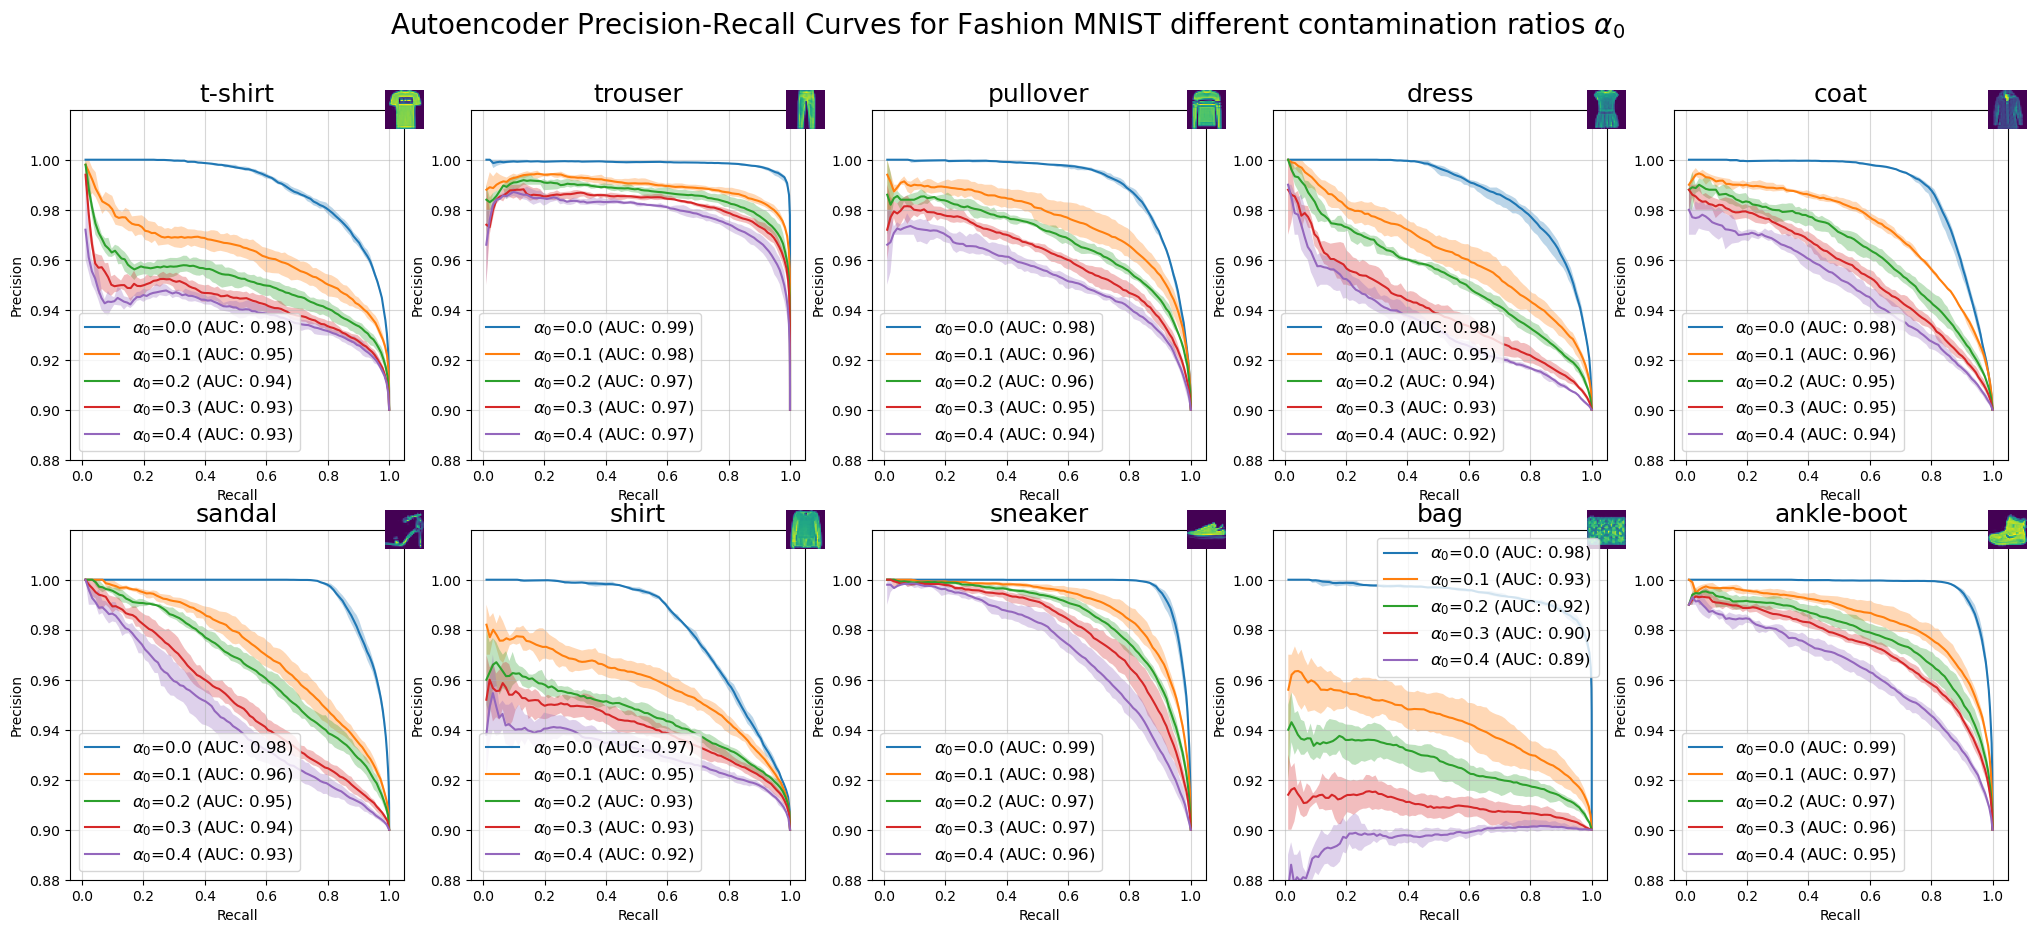

In [22]:
# comparing multiple runs of the same model AE3
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/AE3")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name))
    dataframe_list.append(result_)


# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]
#contam_list = [0.0]
title=r'Autoencoder Precision-Recall Curves for Fashion-MNIST different contamination ratios $\alpha_{0}$'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='mse_')

VAE

In [ ]:
# comparing multiple runs of the same model AE3
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/VAE")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name))
    dataframe_list.append(result_)

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]
title=r'VAE Precision-Recall Curves for Fashion MNIST different contamination ratios $\alpha_{0}$'
plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='mse_')


One Class SVM

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/OneClassSVM")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name))
    
    # scale the scores to be between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = result_[['scores_']] 
    scaled_data = scaler.fit_transform(data)
    result_['scores_'] = scaled_data
    # invert the scores so that the higher the score the more anomalous
    result_['scores_'] = result_['scores_']*-1 +1

    dataframe_list.append(result_)

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]

title=r'OneClassSVM Precision-Recall Curves for Fashion MNIST different contamination ratios $\alpha_{0}$'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='scores_')


LOF Local outlier Factor

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/LOF")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name))
    

    # mak the scores positive
    result_['scores_'] = abs(result_['scores_'])


    dataframe_list.append(result_)



# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]

title=r'LOFPrecision-Recall Curves for Fashion MNIST different contamination ratios $\alpha_{0}$'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='scores_')

Isolation Forest

|████████████████████████████████████████| 10/10 [100%] in 27.5s (0.35/s)       


/tmp/ipykernel_32053/2916392523.py:116: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


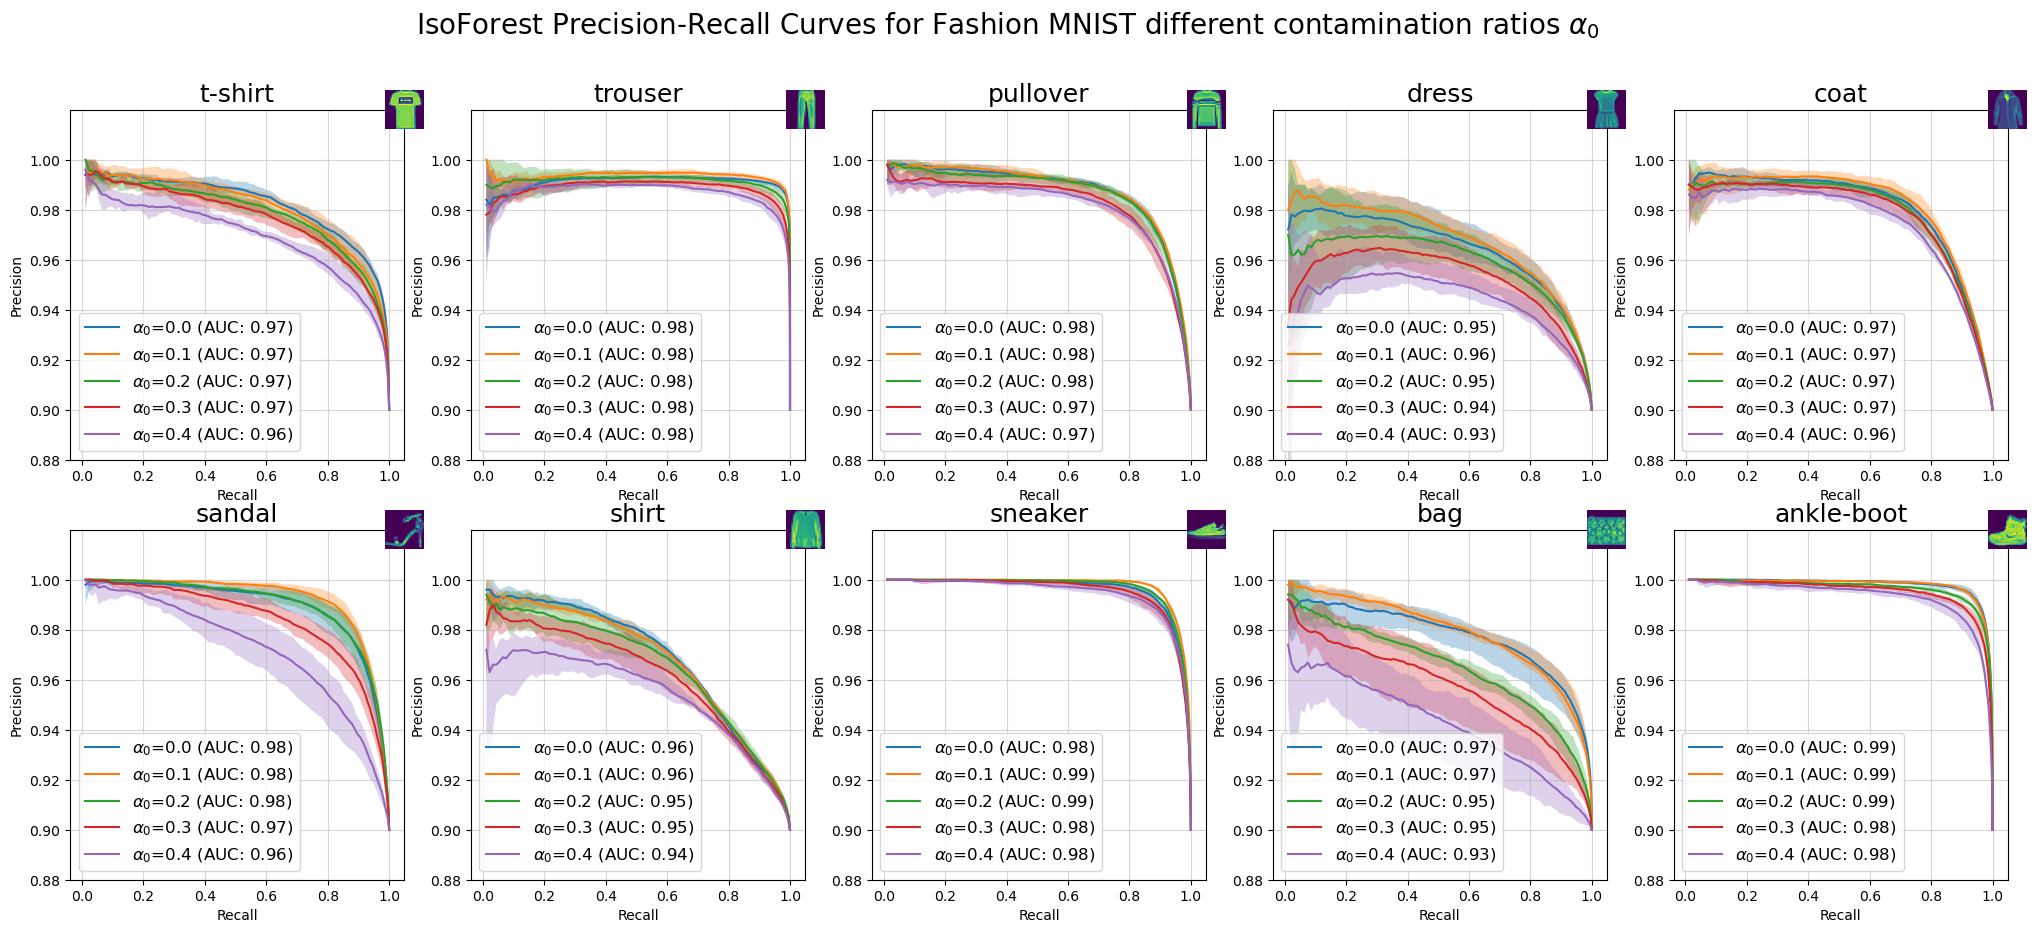

In [3]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/IsoForest")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    result_= pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name))
    
    # invert the scores so that the higher the score the more anomalous
    result_['scores_'] = result_['scores_']*-1
    dataframe_list.append(result_)
# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]

title=r'IsoForest Precision-Recall Curves for Fashion MNIST different contamination ratios $\alpha_{0}$'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='scores_')

# NTL

NTL hard known alpha

|████████████████████████████████████████| 10/10 [100%] in 27.3s (0.35/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:302: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


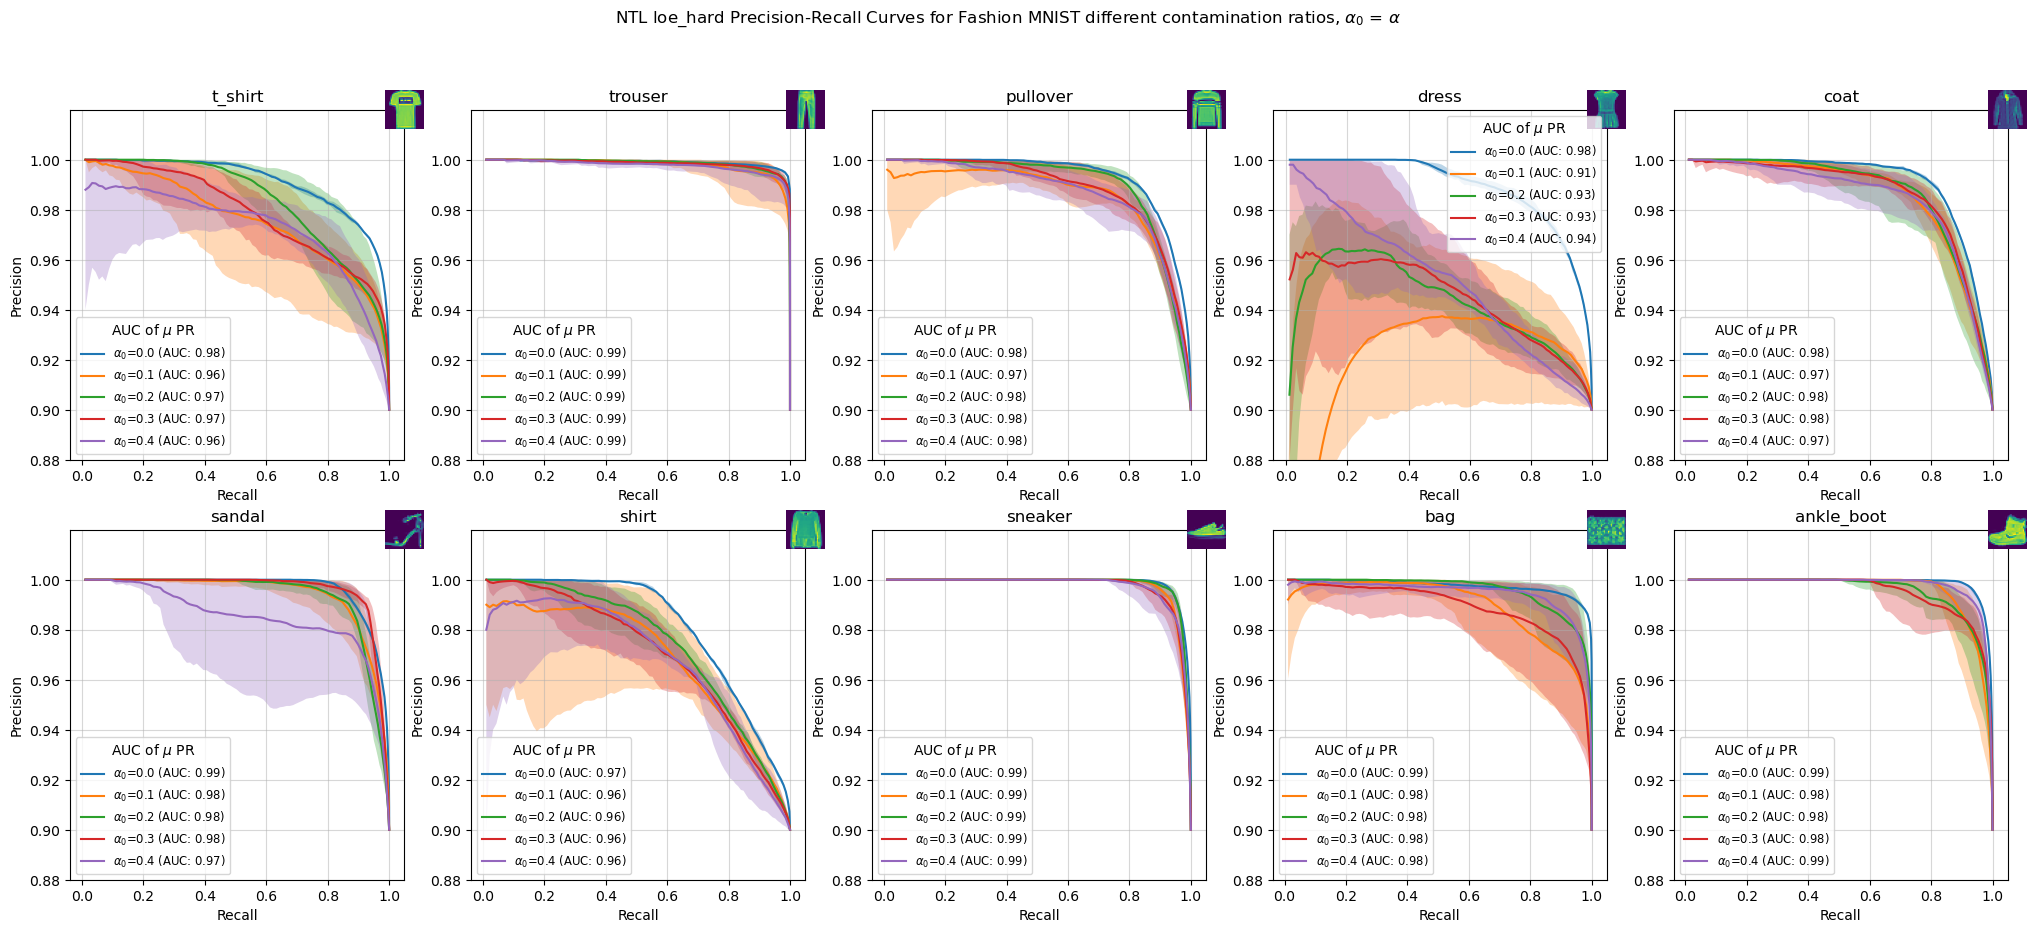

In [2]:
model="loe_hard"
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]
assumed_contamination=0.0

plot_pr_ntl(assumed_contamination=assumed_contamination,model=model,contam_list=contam_list)

NTL blind

|████████████████████████████████████████| 10/10 [100%] in 28.1s (0.34/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:301: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


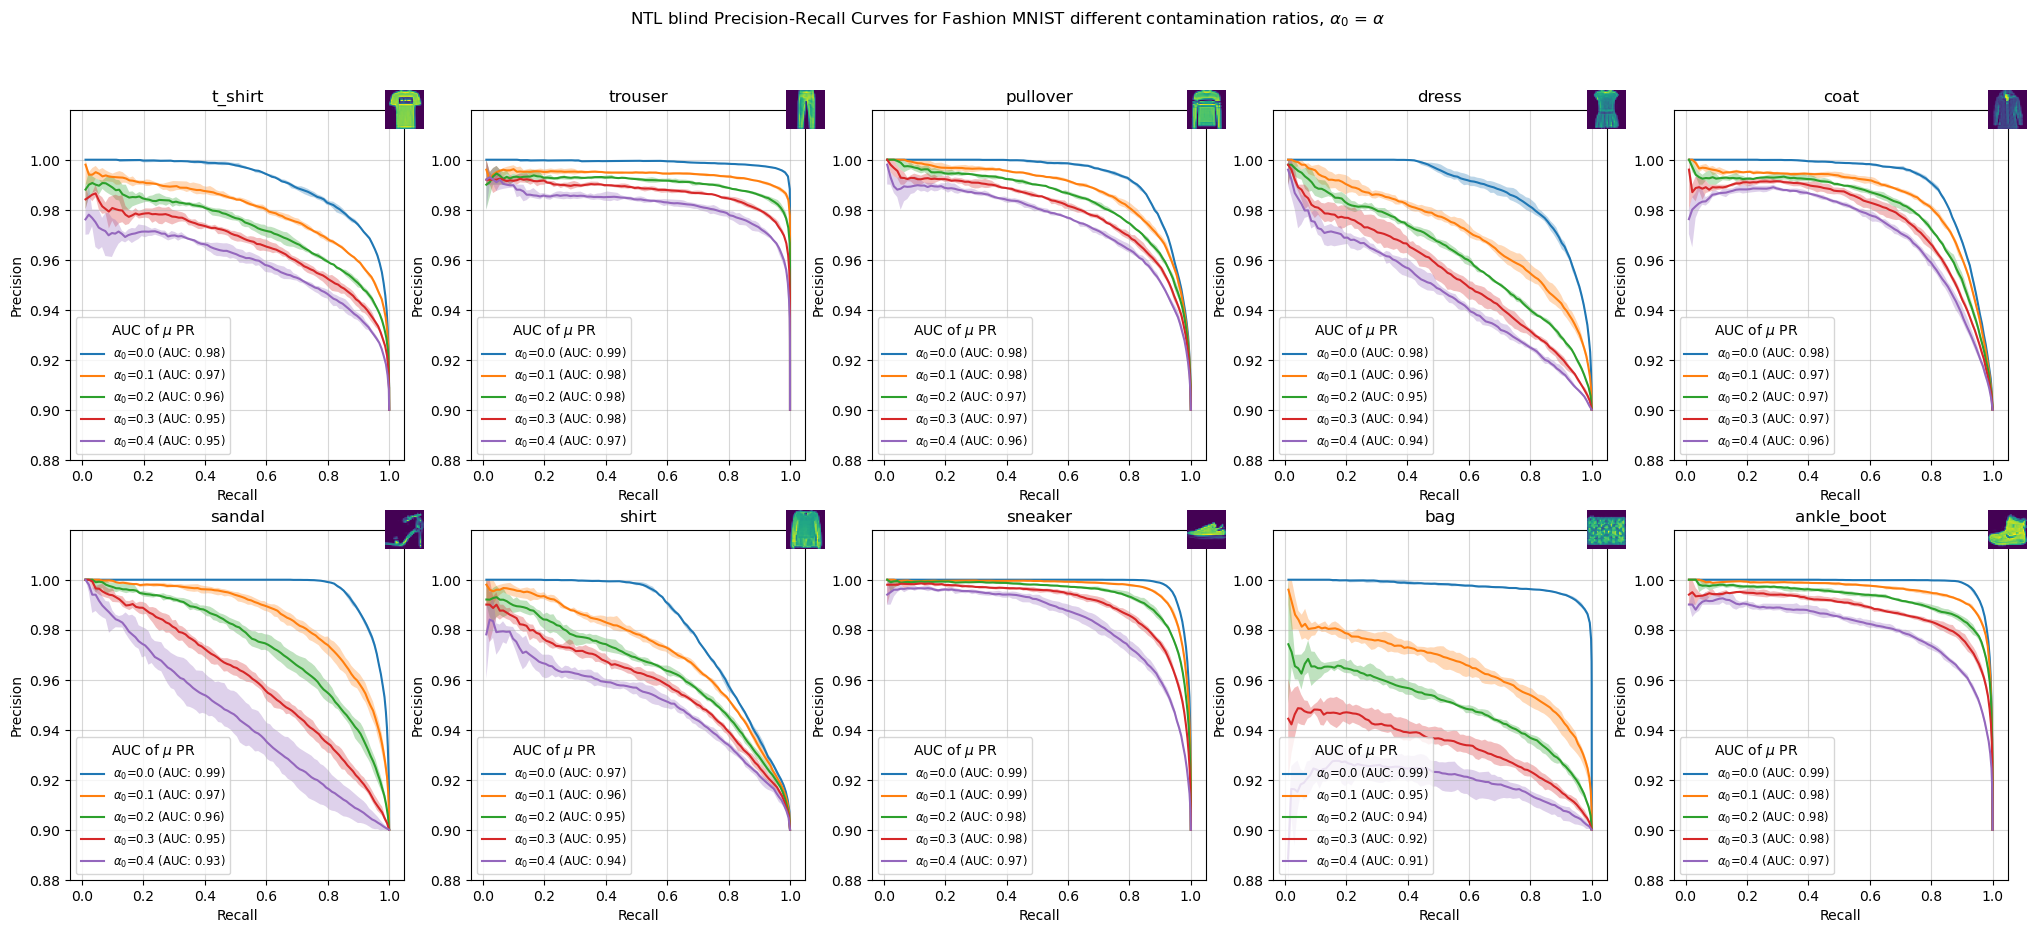

In [15]:
model="blind"# "loe_hard_assumed_contam" 
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]
assumed_contamination=0.0

plot_pr_ntl(assumed_contamination=assumed_contamination,model=model,contam_list=contam_list)

In [16]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/blind_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL -blind Precision-Recall Curves for Fashion MNIST different contamination ratios $\alpha_{0}$'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

|████████████████████████████████████████| 10/10 [100%] in 28.3s (0.34/s)       


ValueError: 
NTL -blind Precision-Recall Curves for Fashion MNIST different contamination ratios $lpha_{0}$
                                                                                    ^
ParseException: Expected end of text, found '$'  (at char 84), (line:1, col:85)

Error in callback <function _draw_all_if_interactive at 0x7f5333ae91f0> (for post_execute):


ValueError: 
NTL -blind Precision-Recall Curves for Fashion MNIST different contamination ratios $lpha_{0}$
                                                                                    ^
ParseException: Expected end of text, found '$'  (at char 84), (line:1, col:85)

ValueError: 
NTL -blind Precision-Recall Curves for Fashion MNIST different contamination ratios $lpha_{0}$
                                                                                    ^
ParseException: Expected end of text, found '$'  (at char 84), (line:1, col:85)

<Figure size 2500x1000 with 10 Axes>

NTL hard loe assumed contamination ratio = 0.0 should be same as blind

|████████████████████████████████████████| 10/10 [100%] in 28.3s (0.34/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:301: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


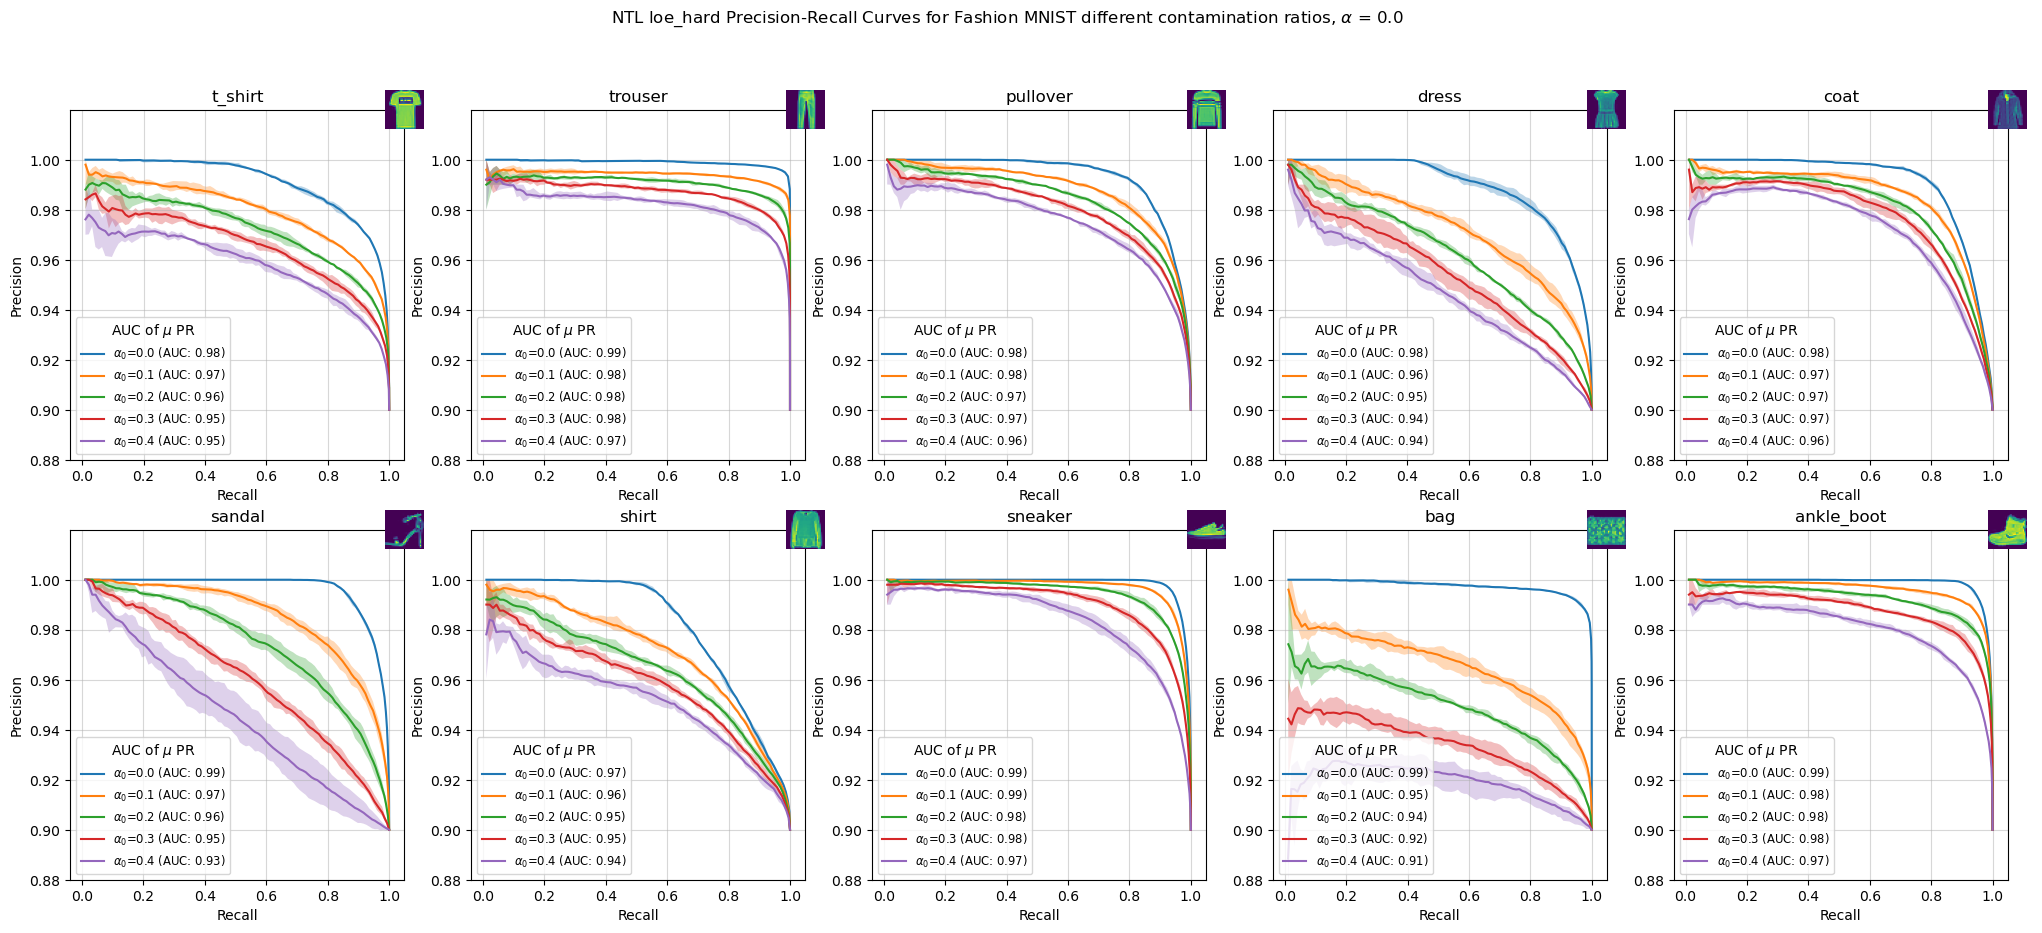

In [12]:
model="loe_hard_assumed_contam"
contam_list = [0.0, 0.1, 0.2,0.3, 0.4]
assumed_contamination=0.0

plot_pr_ntl(assumed_contamination=assumed_contamination,model=model,contam_list=contam_list)

NTL Soft assumed contamination ratio = 0.0 should be same as blind 

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_soft_assumed_contam_0.0_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_soft Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.0'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL hard loe assumed contamination ratio = 0.1 

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_hard_assumed_contam_0.1_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_hard Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.1'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL hard loe assumed contamination ratio = 0.2

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference
MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_hard_assumed_contam_0.2_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_hard Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.2'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL loe hard assumed contamination ratio = 0.3

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_hard_assumed_contam_0.3_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_hard Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.3'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL loe hard assumed contamination ratio = 0.4

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_hard_assumed_contam_0.4_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_hard Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.4'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL loe_soft assumed contamination is 0.1

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_soft_assumed_contam_0.1_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_soft Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.1'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL loe_soft assumed contamination is 0.2

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_soft_assumed_contam_0.2_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_soft Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.2'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL loe_soft assumed contamination is 0.3

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_soft_assumed_contam_0.3_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_soft Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.3'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL loe_soft assumed contamination is 0.4

In [ ]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/loe_soft_assumed_contam_0.4_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL loe_soft Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.4'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL refine assumed contamination is 0.0

|████████████████████████████████████████| 10/10 [100%] in 27.9s (0.34/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:302: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


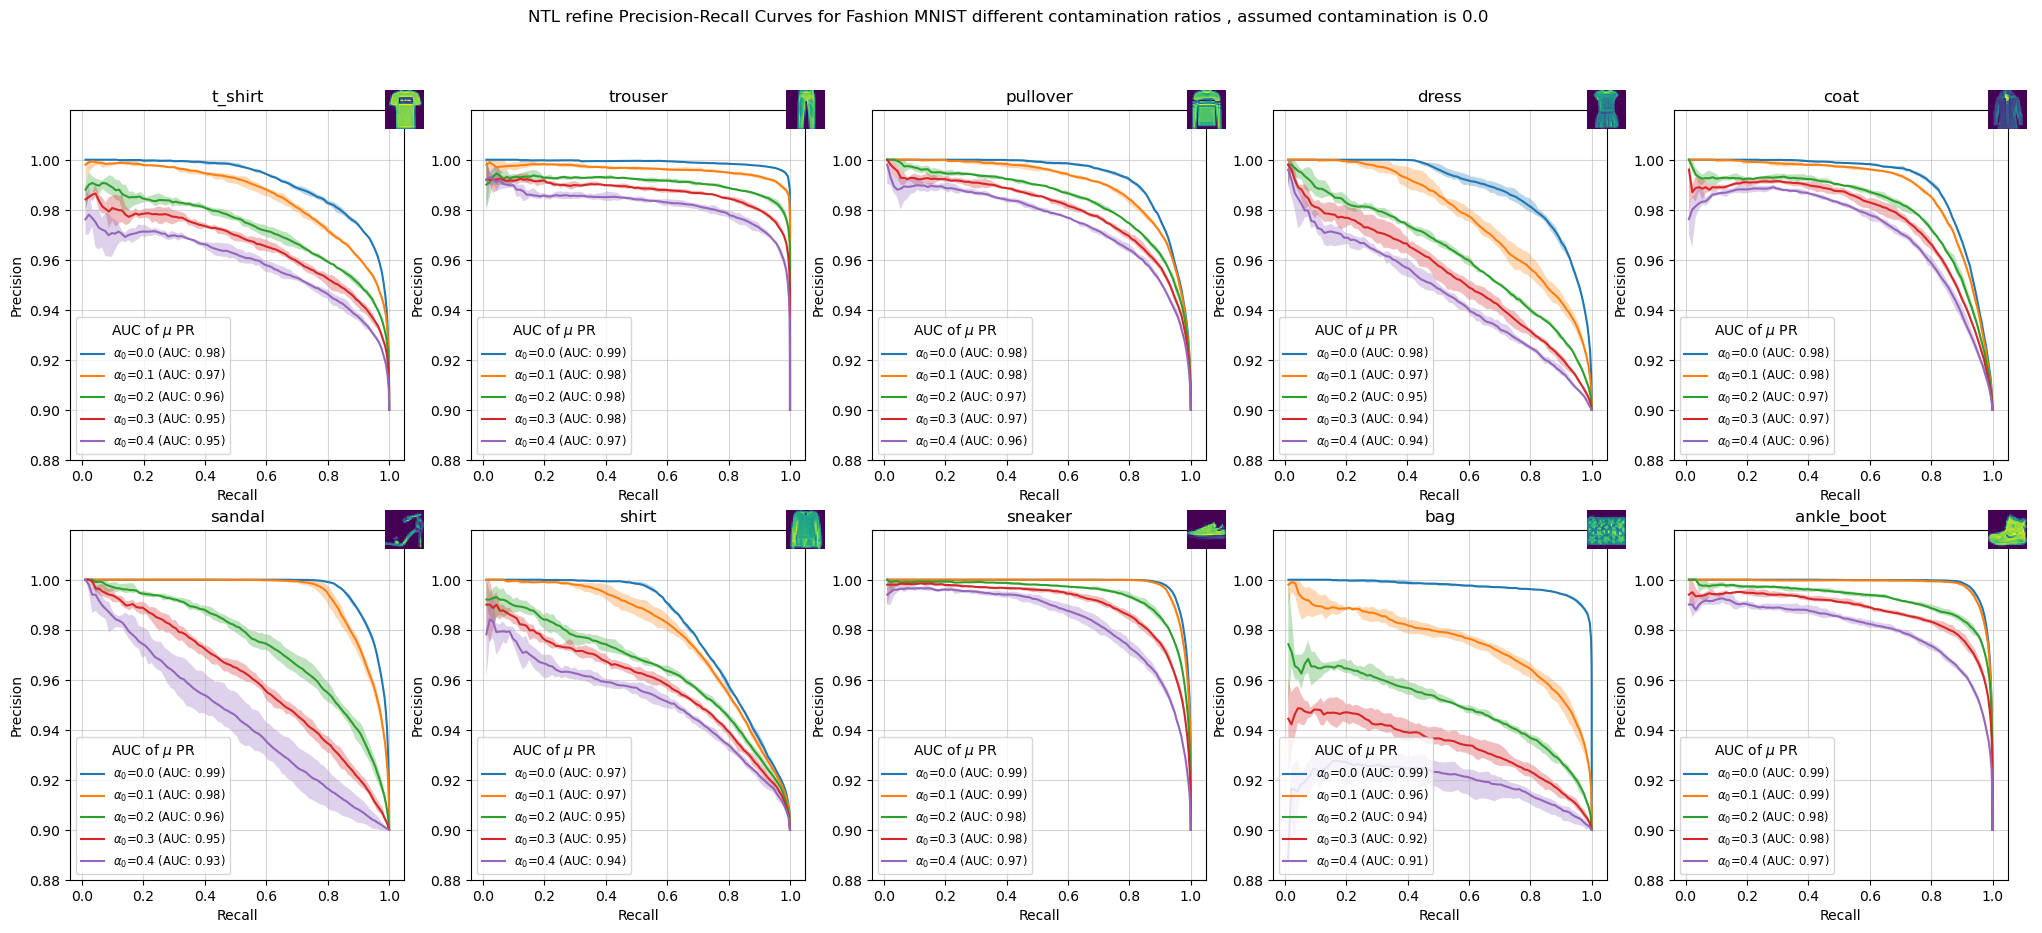

In [3]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/refine_assumed_contam_0.0_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL refine Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.0'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL refine assumed contamination is 0.1

|████████████████████████████████████████| 10/10 [100%] in 28.2s (0.34/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:302: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


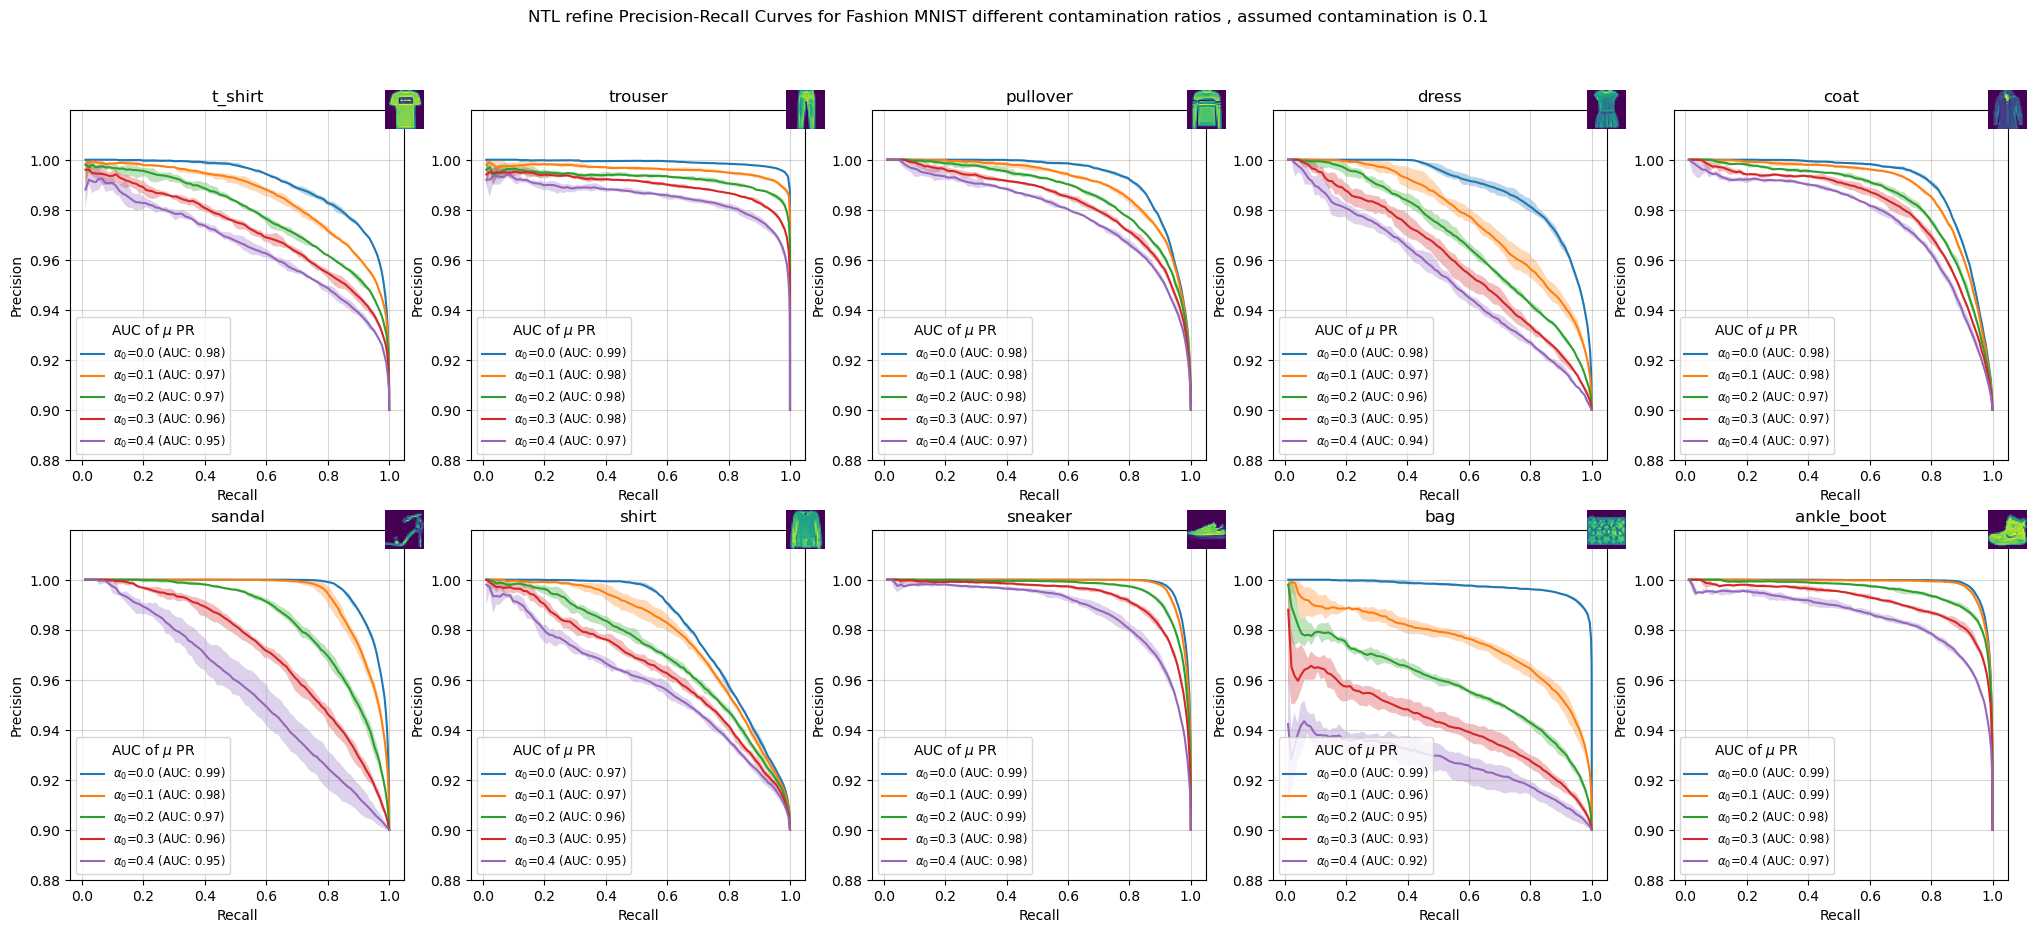

In [4]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/refine_assumed_contam_0.1_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL refine Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.1'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL refine assumed contamination is 0.2

|████████████████████████████████████████| 10/10 [100%] in 27.5s (0.35/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:302: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


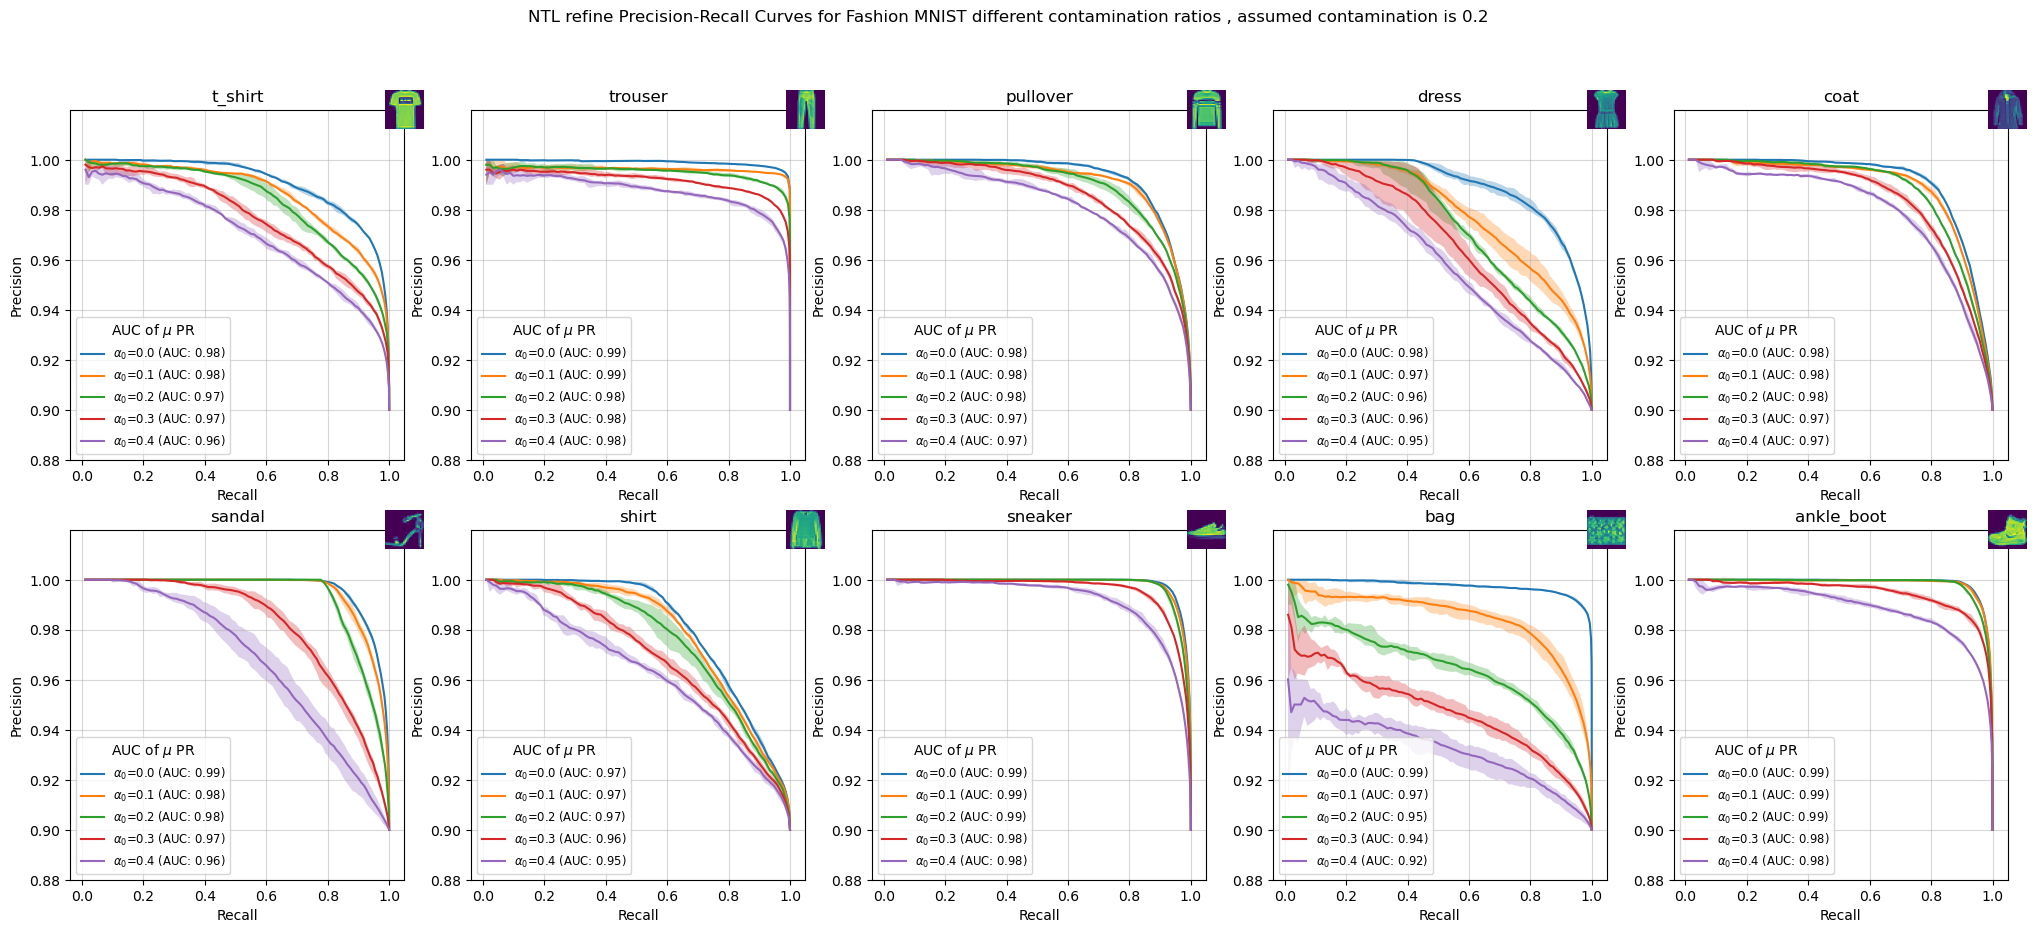

In [5]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/refine_assumed_contam_0.2_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL refine Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.2'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL refine assumed contamination is 0.3

|████████████████████████████████████████| 10/10 [100%] in 28.0s (0.34/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:302: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


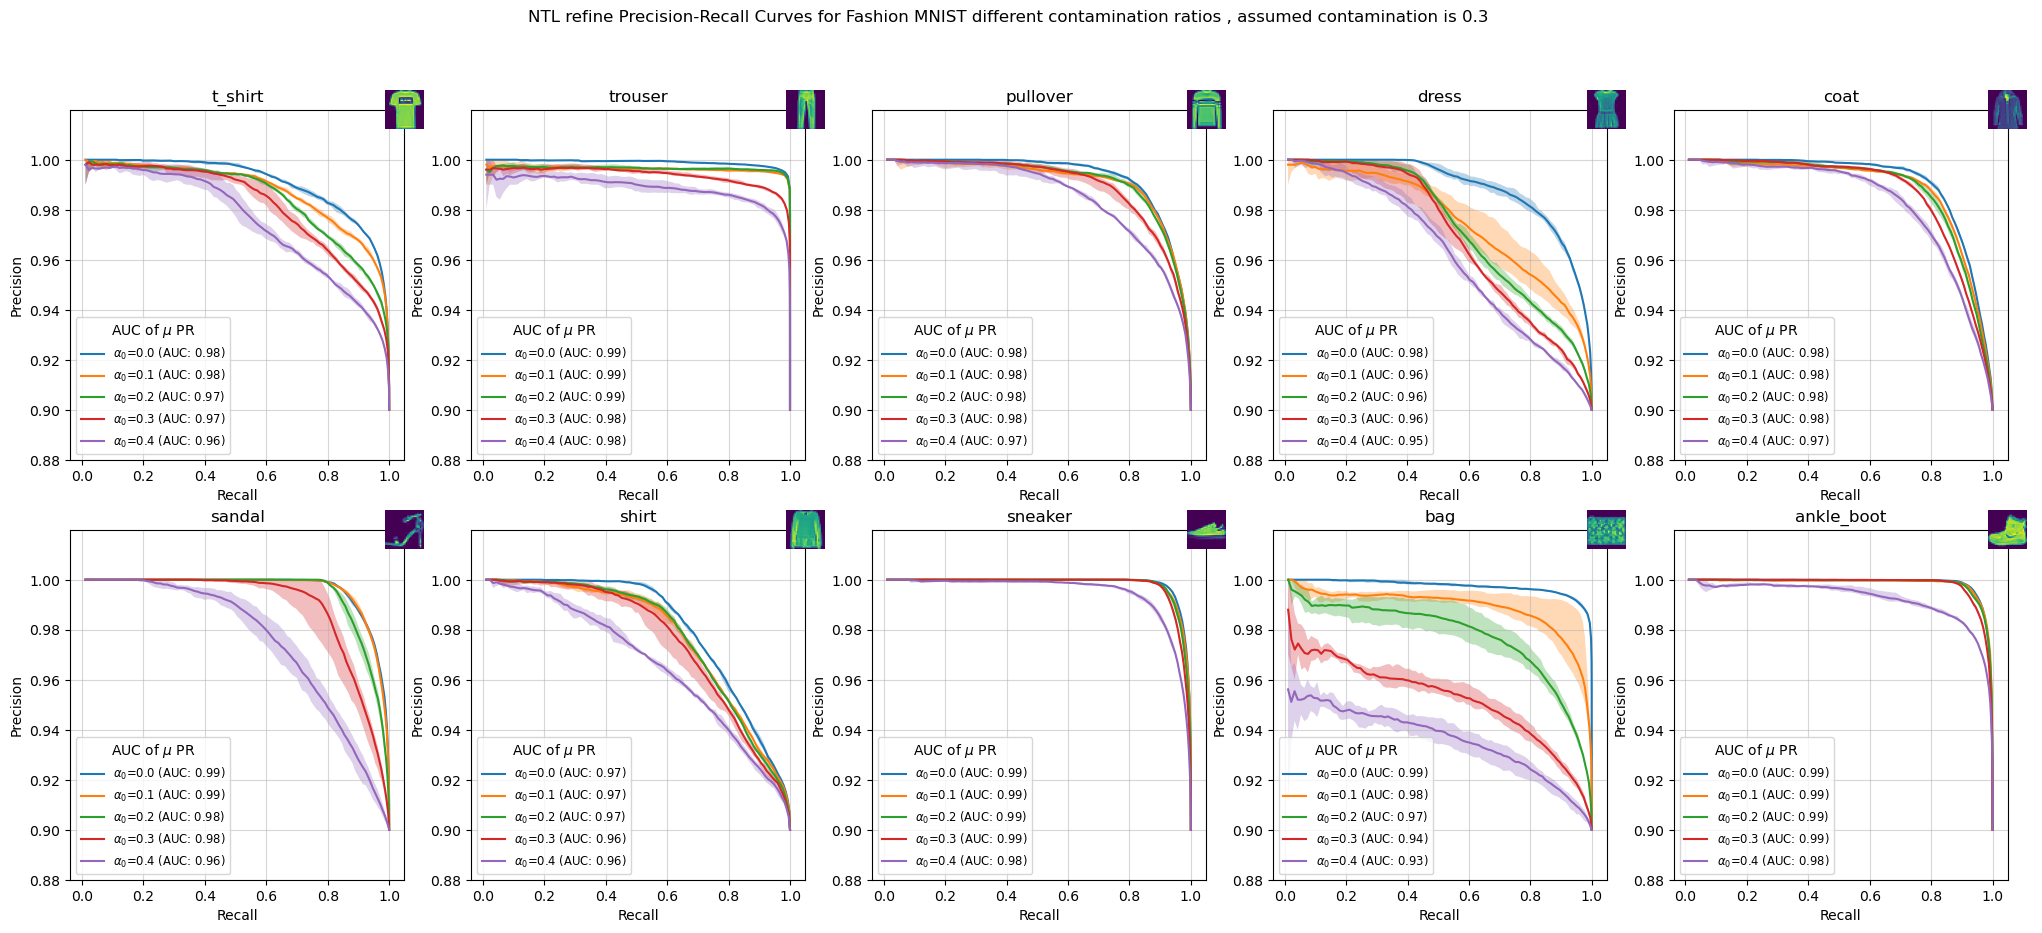

In [6]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/refine_assumed_contam_0.3_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL refine Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.3'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')

NTL refine assumed contamination is 0.4

|████████████████████████████████████████| 10/10 [100%] in 27.5s (0.35/s)       


/root/LatentOE-AD/Additional_Code_BULE/utils/helper_functions.py:302: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


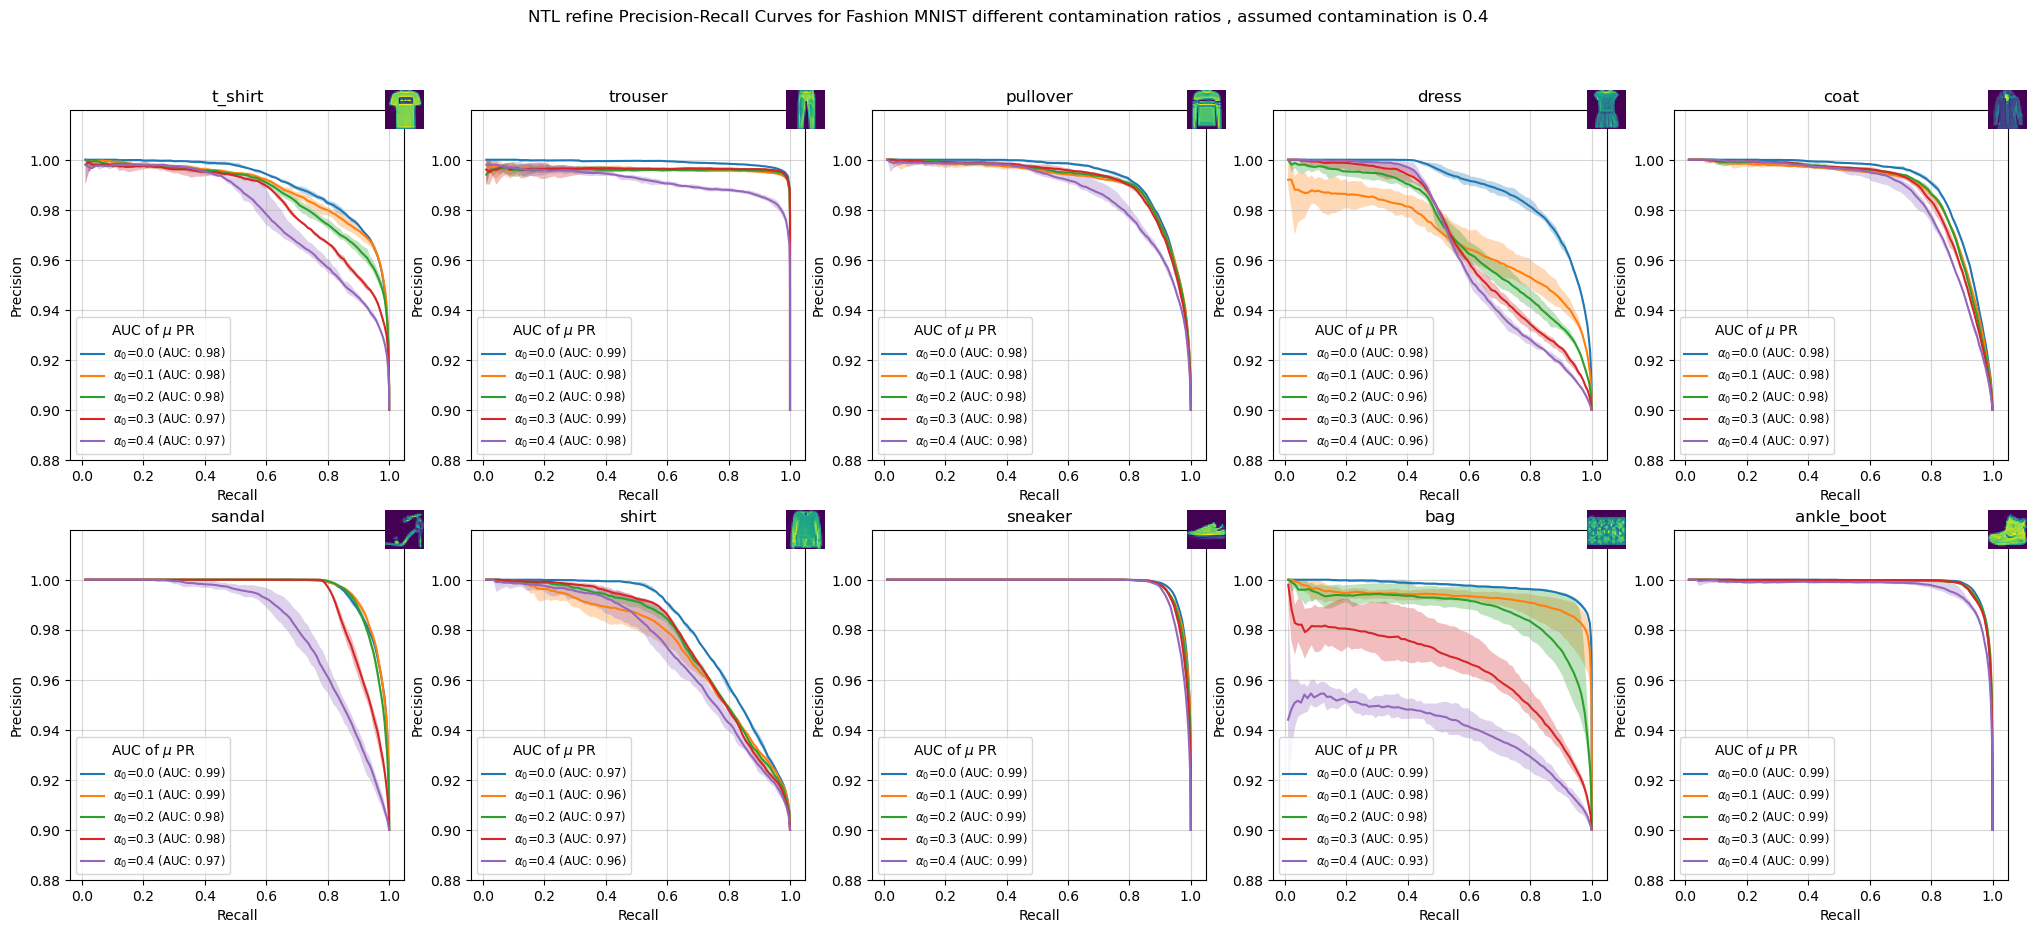

In [7]:
# comparing multiple runs of the same model oneclassSVM
plt.rcParams["figure.figsize"] = (25, 10)  # Adjust the figure size as per your preference

MODEL_RESULT_PATH = Path(r"/root/LatentOE-AD/RESULTS/fmnist/refine_assumed_contam_0.4_allresults")

# load the diffent runs in a list
nameslist,dataframe_list=[name for name in os.listdir(MODEL_RESULT_PATH) if "allresults_run_"in name],[]
for name in nameslist:
    dataframe_list.append(pd.read_pickle(os.path.join(MODEL_RESULT_PATH,name)))

# for which contamination ratios we want to see the results
contam_list = [0.0, 0.1, 0.2,0.3,0.4]

title='NTL refine Precision-Recall Curves for Fashion MNIST different contamination ratios , assumed contamination is 0.4'

plot_precision_recall_multi(dataframe_list,plot=True,contam_list=contam_list,show_img=True,sklearn_pr=False,title=title,pred_y='score_')